# BEE 4750 Final Project

Team Members: Bailey Belinger (bcb87), Camila Monter (cm755), Priya Shah (ps742)

In [1]:
# Importing packages
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("JuMP")
Pkg.add("HiGHS")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("Measures")
Pkg.add("CSV")
Pkg.add("MarkdownTables")

using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables
using LinearAlgebra

  Activating project at `~/Downloads/BEE4750/l3bc-final-project`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Project.toml`
    Updating `~/Downloads/BEE4750/l3bc-final-project/Manifest.toml`
  [8e850b90] ↓ libblastrampoline_jll v5.11.0+0 ⇒ v5.8.0+1
   Resolving package versions...
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Project.toml`
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Project.toml`
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Project.toml`
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Downloads/BEE4750/l3bc-final-project/Project.toml`
  No Changes to `~/Do

In [2]:
##Carbon Sequestration Rates

m2 = 0.092903 #conversion to m^2
#Trees
oak_tree_cs = 0.593 #kg C/m2/year
ash_tree_cs = 5.903 #kgC/m2/year
maple_tree_cs = 0.202 #kg C/m2/year

#Green Roof Systems
grass_cs = 0.2 #kg C/m2
prairie_mix_cs = 4.63 #kg C/m2
herb_garden_cs = 11.03 #kg C/m2

##Costs
#Trees
oak_tree_cost = 42.51 #per tree WHEN YOU BUY 10
ash_tree_cost = 109.75 #per tree
maple_tree_cost = 19.99 #per tree

#Green Roof Systems
installation_cost = 30*m2 #$/sqm
maintenance_cost = 1.50*m2 #$/sqm/year
grass_cost = 0.86*m2 #$/sqm
prairie_mix_cost = 0.03*m2 #$/sqm
herb_garden_cost = 9.50*m2 #$/sqm

#Available areas
city_area = 2526871.39 #m^2
total_area = 4761611.96 #m^2
park_area = 1563736.94 #m^2
usable_roof_area = 0.4 #percent of city that is usable rooftop area

#Emission rates in Chicago
current_emission_level = 0.0517 * total_area #kg CO2 / year

30

In [3]:
percent_reduction_goal = 30

air_quality_model = Model(HiGHS.Optimizer)
@variable(air_quality_model, G[1:6]>=0) #area in meters squared

fixed_cost = installation_cost*G[4] +  installation_cost*G[5] +  installation_cost*G[6] + maintenance_cost*G[4] + maintenance_cost*G[5] + maintenance_cost*G[6]
variable_cost = G[1]*oak_tree_cost + G[2]*ash_tree_cost + G[3]*maple_tree_cost + G[4]*grass_cost + G[5]*prairie_mix_cost + G[6]*herb_garden_cost
cost = fixed_cost + variable_cost
@objective(air_quality_model, Min, cost)

#print(air_quality_model)

emissions_reduction = (G[1]*oak_tree_cs + G[2]*ash_tree_cs + G[3]*maple_tree_cs + G[4]*grass_cs + G[5]*prairie_mix_cs + G[6]*herb_garden_cs)*(44/12) #kg CO2 / year
new_total_emissions = current_emission_level - emissions_reduction
percent_reduction = (current_emission_level - new_total_emissions)/current_emission_level * 100
@constraint(air_quality_model, emisisons_constraint, percent_reduction >= percent_reduction_goal)
@constraint(air_quality_model, area_constraint_park, G[1]+G[2]+G[3] <= park_area)
@constraint(air_quality_model, area_constraint_rooftop, G[4]+G[5]+G[6] <= usable_roof_area*city_area)

# Optimize the model
optimize!(air_quality_model)

# Display the optimized values
println("Optimal oak trees ", value.(G[1])*15)
println("Optimal ash trees ", value.(G[2])*15*m2)
println("Optimal maple trees ", value.(G[3])*40*m2)
println("Optimal grass area ", value.(G[4]))
println("Optimal prarie mix area ", value.(G[5]))
println("Optimal herb garden area ", value.(G[6]))

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [3e+01, 2e+06]
Presolving model
3 rows, 6 cols, 12 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
Presolve : Reductions: rows 3(-0); columns 6(-0); elements 12(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(480) 0s
          1     6.9555655911e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  6.9555655911e+03
HiGHS run time      :          0.00
Optimal oak trees 0.0
Optimal ash trees 0.0
Optimal maple trees 0.0
Optimal grass area 0.0
Optimal prarie mix area 0.0
Optimal herb garden area 1826.0760281776975


Coefficient ranges:
  Matrix [3e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 2e+06]
Presolving model
5 rows, 6 cols, 24 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
Presolve : Reductions: rows 3(-2); columns 6(-0); elements 12(-12)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(480) 0s
          1     6.9555655911e+03 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  6.9555655911e+03
HiGHS run time      :          0.00
Coefficient ranges:
  Matrix [3e-04, 1e+00]
  Cost   [3e+00, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 2e+06]
Presolving model
5 rows, 6 cols, 24 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
3 rows, 6 cols, 12 nonzeros  0s
Presolve : Reductions: rows 3(-2); columns 6(-0); elements 12(-12)
Solvin

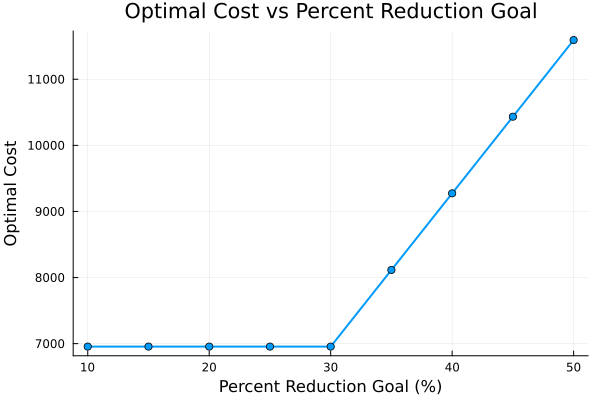

In [8]:
using JuMP, HiGHS, Plots

# Define the range of percent reduction goals
percent_reduction_goals = 10:5:50 # from 10% to 50% in increments of 5%
optimal_costs = []

# Loop over each percent reduction goal
for goal in percent_reduction_goals
    # Add a temporary constraint for the current percent reduction goal
    temp_constraint = @constraint(air_quality_model, percent_reduction >= goal)
    
    # Solve the model
    optimize!(air_quality_model)
    
    push!(optimal_costs, objective_value(air_quality_model))

    # Remove the temporary constraint before the next iteration
    delete(air_quality_model, temp_constraint)
end

# Plot the results
plot(percent_reduction_goals, optimal_costs, xlabel="Percent Reduction Goal (%)", ylabel="Optimal Cost",
    title="Optimal Cost vs Percent Reduction Goal", lw=2, marker=:circle, legend=false)